En este script se entrena y predice el modelo LSTM- Variacion de la Regresion Lineal.
En particular este archivo es para entrenar con varios conjuntis de datos y probar con uno solo.

In [1]:
import os
import pickle
import numpy 
import pandas as pd
#import cv2
import matplotlib.pyplot as plt
from PIL import Image
from pylab import *
from matplotlib import pyplot
#from numpy import *
from scipy. ndimage import filters
import pandas as pd
import os
from keras.models import Model, Sequential, save_model, load_model
import math
from sklearn.metrics import mean_squared_error

import random
from sklearn.preprocessing import MinMaxScaler
import h5py
import tensorflow as tf


Using TensorFlow backend.


In [2]:
import os 
import pickle
import numpy as np
import random

def preprocess(data_dirs, data_file,name):
    # all_ped_data would be a dictionary with mapping from each ped to their
    # trajectories given by matrix 3 x numPoints with each column
    # in the order x, y, frameId
    # Pedestrians from all datasets are combined
    # Dataset pedestrian indices are stored in dataset_indices
    all_ped_data = {}
    dataset_indices = []
    current_ped = 0
    # For each dataset
    for directory in data_dirs:
        # Define the path to its respective csv file
        #PETS2009-S2L1-mmundo.csv
        #'PETS09-S2L1.txt'
        file_path = os.path.join(directory,name )

        # Cargar datos desde el archivo csv
        # Los datos son una matriz 4x numTrajPoints
        
        
        data = np.genfromtxt(file_path, delimiter=',')
       
        
        # Obtenga el numero de peatones en el conjunto de datos actual
        uni=np.unique(data[:,1])    
        numPeds=np.size(np.unique(data[:,1]))
        print("El numero de peatones en"+ directory+" es "+str(numPeds))

       
        # Para cada peaton en el conjunto de datos
        for ped in range(1, numPeds+1):
            #Son los datos de la persona ped
            traj = data[ data[:, 1] == ped]
            #Esta como (x,y,frame_Id)
            traj = traj[:, [2,3,0]]
            
            #Esta como [[x,...],[y,...],[Frame_Id,..]]
            traj=[list(traj[:,0]),list(traj[:,1]),list(traj[:,2])]
            all_ped_data[current_ped + ped] = np.array(traj)

        # Current dataset done
        dataset_indices.append(current_ped+numPeds)
        current_ped += numPeds

    # Los datos completos son una tupla de todos los datos de peatones y los indices de datos del conjunto de datos.
    complete_data = (all_ped_data, dataset_indices)
    # Almacena los datos completos en el archivo pickle
    f = open(data_file, "wb")
    pickle.dump(complete_data, f, protocol=2)
    f.close()
    return complete_data
    

In [3]:
def load_preprocessed(data_file,seq_length_obs,batch_size):
    
    # cargar los datos
    f = open(data_file, "rb")
    raw_data = pickle.load(f)
    f.close()

    # Obtengo los peatones
    all_ped_data =raw_data[0]
 
    #all_ped_data es el vector {[[],[],[]],...,[[],[],[]]} tantos como pedestrian hayan
    # No usamos dataset_indices por ahora
    # dataset_indices = self.raw_data[1]

    # Construimos data con secuencias(o trayectorias) del largo than seq_length_obs
    data = []
    counter = 0

    # para cada peaton en data
    for ped in all_ped_data:
        
        #ped es un numero entero y va de 1 hasta la cantidad total de pedestrian
        # Extract his trajectory
        traj = all_ped_data[ped]
        
           
        # If the length of the trajectory is greater than seq_length (+2 as we need both source and target data)
        #solo se toman las trajectorias de longitud mayor a seq_length+2
        if traj.shape[1] >= (seq_length_obs+1):
            # TODO: (Improve) Store only the (x,y) coordinates for now
               
            data.append(traj[[0, 1], :].T)
            #print(traj[[0, 1], :].T)
            # Number of batches this datapoint is worth
            #print(traj.shape[1] )
            #print(int(traj.shape[1] / ((seq_length_obs+1))))
            counter += int(traj.shape[1] / ((seq_length_obs+1)))
        
    # Calculate the number of batches (each of batch_size) in the data
    #counter tiene la cantidad de bloques de 8 pasos
        
    num_batches = int(counter /batch_size)
    #cada bache tiene batch_size conjuntos donde cada conjunto tiene datos de length+2
    return data,num_batches

In [4]:

data_dirs = ['../data1/ucy/zara/zara02','../data1/ucy/zara/zara01',
             '../data1/ucy/univ','../data1/eth/hotel','../data1/eth/univ']

dim_image = [[720,576],[720,576],[720,576],[720,576],[640,480]]

# aqui se pone indice del dataset que va a ser el de prueba
indice_test = 4

image_size = dim_image[indice_test]

datasets = range(5)
datasets = list(datasets)
datasets.remove(indice_test)

used_data_dirs = [data_dirs[x] for x in datasets]

#Directorio de datos donde reside el archivo pickle preprocesado
data_dir = '../data1'

#Defina la ruta del archivo en el que deben almacenarse los datos.
data_file = os.path.join(data_dir, "datos_limpios_.cpkl")

name ='pixel_pos.csv'

#print(used_data_dirs)
data = preprocess(used_data_dirs, data_file,name)
datos,numero = load_preprocessed(data_file,8,1)
print("El numero de muestras es de "+str(numero))

El numero de peatones en../data1/ucy/zara/zara02 es 204
El numero de peatones en../data1/ucy/zara/zara01 es 148
El numero de peatones en../data1/ucy/univ es 434
El numero de peatones en../data1/eth/hotel es 390
El numero de muestras es de 3832


In [5]:
#funcion para preparar los datos para el entrenamiento de la red
def secuencia(seq_length_obs,data):
    tamano=int(len(data))
    
    X,Y = [],[]
    for j in range(tamano):
        traj = data[j]
        lon = traj.shape[0]-seq_length_obs
        
        for i in range(0,lon):
            total = traj[i:(i + seq_length_obs ), :]
            X.append(total)
            xx = traj[i:(i + seq_length_obs ), 0]
            yy = traj[i:(i + seq_length_obs ), 1]
            
            #calculamos la x,y con regresion
            t = range(1,len(xx)+1)
            x_mean = np.mean(xx)
            t_mean = np.mean(t)
            t_var = np.var(t)
            #print(t_var)
            xt_cov = np.cov (xx, t)[0][1]
            vx = xt_cov/t_var
            x0 = x_mean-(vx*t_mean)
            
            y_mean = np.mean(yy)
            yt_cov = np.cov (yy, t)[0][1]
            
            vy = yt_cov/t_var
            y0 = y_mean-(vy*t_mean)
            
            x_next = x0+vx*(len(xx)+1)
            y_next = y0+vy*(len(yy)+1)
            #print("aqui imprimooooo................")
            #print(x_next,y_next)
            #print(traj[i+seq_length_obs, :])
            Y.append(traj[i+seq_length_obs, :]-[x_next,y_next])
    return np.array(X), np.array(Y)

# Visualizacion de los datos de entrenamiento

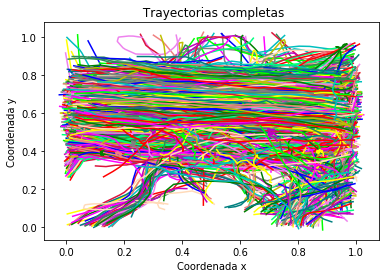

In [6]:
# import random
color_names = ["r","crimson" ,"g", "b","c","m","y","lightcoral", "peachpuff","grey","springgreen" ,"fuchsia","violet","teal","seagreen","lime","yellow","coral","aquamarine","hotpink"]

for i in range(len(datos)):
    cpu = random.choice(range(17))
    pintar = plt.plot(datos[i][:,0],datos[i][:,1],color=color_names[cpu])
plt.title(" Trayectorias completas") 
plt.xlabel("Coordenada x")   
plt.ylabel("Coordenada y") 

#plt.savefig("trayectorias.jpg")
plt.show() 

# Preparacion de los datos de entrenamiento

In [ ]:
length_obs = 8
trainX,trainY = secuencia(length_obs,datos)

In [ ]:
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1],trainX.shape[2]))

In [ ]:
data_shape = trainX.shape[1:]
print(data_shape)
import numpy as np
np.shape(trainX)

# Modelo

In [ ]:
from keras.models import Sequential
from keras import optimizers
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
from keras import initializers
from datetime import datetime



if 'model' in globals(): del model
model = None
model = Sequential()
model.add(LSTM(9, return_sequences=True, input_shape=data_shape, name='lstm1'))
model.add(LSTM(9, name='lstm2'))
model.add(Dense(2))

In [ ]:
#opt1=optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-2, amsgrad=False)
opt = optimizers.RMSprop(lr = 0.006, decay=1e-2)
model.compile( optimizer=opt,loss='logcosh',metrics=['mse'])
history=model.fit(trainX, trainY, epochs=100, batch_size=16, verbose=2 )

In [ ]:
history_dict=history.history
history_dict.keys()

In [ ]:
acc = history.history['mean_squared_error']
#val_acc = history.history['val_mean_squared_error']
loss = history.history['loss']
#val_loss = history.history['val_loss']

epochs = range(1, len(loss)+1)

# figure
plt.figure(figsize=(13,6))
plt.subplot(1,2,1)
plt.plot(epochs, loss, 'b', label='Training loss')
#plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(epochs, acc, 'r', label='Training mse')
#plt.plot(epochs, val_acc, 'g', label='Validation mse')
plt.title('Training mse')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.savefig("lstm-regresion2-simplificado.pdf")
plt.show()

# Modelos de pets con framerate de 3.75 frames por segundo

In [ ]:
#model.save('lstm-regre-ucy-univ.h5')

In [ ]:
#model.save('lstm-regre-eth-hotel.h5')

In [ ]:
#model.save('lstm-regre-ucy-zara-zara01.h5')

In [ ]:
#model.save('lstm-regre-ucy-zara-zara02.h5')

In [ ]:
#model.save('lstm-regre-eth-univ.h5')

# Se carga el modelo con el que se va a predecir

In [7]:
modelregre = load_model('lstm-regre-eth-univ.h5')

W0328 23:44:18.476950 139989331457792 deprecation_wrapper.py:119] From /home/andrea/anaconda2/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0328 23:44:18.500603 139989331457792 deprecation_wrapper.py:119] From /home/andrea/anaconda2/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0328 23:44:18.504096 139989331457792 deprecation_wrapper.py:119] From /home/andrea/anaconda2/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0328 23:44:18.848004 139989331457792 deprecation_wrapper.py:119] From /home/andrea/anaconda2/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_se

# Aqui se procesa el conjunto de test

In [8]:
dataset_test=[indice_test]

used_data_dirs = [data_dirs[x] for x in dataset_test]
#Directorio de datos donde reside el archivo pickle preprocesado
data_dir = '../data1'

#Defina la ruta del archivo en el que deben almacenarse los datos.
data_file = os.path.join(data_dir, "datos_limpios_prueba.cpkl")

name ='pixel_pos.csv'
# If the file doesn't exist already or if forcePreProcess is true
#se usa preprocesscsv para los csv y preprocess para el .txt

#print(used_data_dirs)
data1 = preprocess(used_data_dirs, data_file,name)

# la segunda entrada es la suma de obs + pred
datos_prueb,numero = load_preprocessed(data_file,12,1)

El numero de peatones en../data1/eth/univ es 360


# PREDICCION

In [9]:
def error_desplazamiento_final(predicted_traj, true_traj):
    tam = len(predicted_traj)
    return np.linalg.norm(predicted_traj[tam-1]-true_traj[tam-1])

In [10]:
def error_promedio(predicted_traj, true_traj, observed_length):
    
    error = np.zeros(len(true_traj) - observed_length)
    # PARA CADA PUNTO EN LA TRAYECTORIA PREDICHA
    for i in range(observed_length, len(true_traj)):
        # The predicted position
        pred_pos = predicted_traj[i]
        # The true position
        true_pos = true_traj[i]

        # The euclidean distance is the error
        error[i-observed_length] = np.linalg.norm(true_pos - pred_pos)

    # Return the mean error
    return np.mean(error)


In [11]:
#Funcion para preparar el conjunto de test para predecir una cierta cantidad de pasos 
def secuencia_pred(seq_length_obs,data,seq_length_pred):
    tamano = int(len(data))
    
    X,Y_true = [],[]
    for j in range(tamano):
        traj = data[j]
        lon = traj.shape[0]-seq_length_obs-seq_length_pred
        
        for i in range(0,lon+1):
            a = traj[i:(i+seq_length_obs),:]
            X.append(a)
            b = traj[i:(i+seq_length_obs+seq_length_pred),:]
            Y_true.append(b)
    return np.array(X),np.array(Y_true)

In [12]:
#Funcion para medir el modelo con el conjunto de test
def sample(test,seq_length_obs,seq_length_pred):
    
    X,Y_true = secuencia_pred(seq_length_obs,test,seq_length_pred)
    total_error = 0.0
    total_final = 0.0
    
    todo = []
    for i in range(len(X)):
        traj_obs = X[i]
        traj_pred = X[i]
        
        for j in range(seq_length_pred):
            traj_obsr = numpy.reshape(traj_obs, (1,traj_obs.shape[0],traj_obs.shape[1]) )
            predict = modelregre.predict(traj_obsr)
             
            xx = traj_obs[:,0]
            yy = traj_obs[:,1]
            
            t = range(1,len(xx)+1)
            x_mean = np.mean(xx)
            t_mean = np.mean(t)
            t_var = np.var(t)
            xt_cov = np.cov (xx, t)[0][1]
            vx = xt_cov/(t_var)
            x0 = x_mean-(vx*t_mean)
            
            y_mean = np.mean(yy)
            yt_cov = np.cov (yy, t)[0][1]
            
            vy = yt_cov/(t_var)
            y0= y_mean-(vy*t_mean)
            
            x_next = x0+vx*(len(xx)+1)
            y_next = y0+vy*(len(yy)+1)
            
        
            next_point = [x_next,y_next]+predict
            
            traj_obs = np.concatenate((traj_obs[1:len(traj_obs)],next_point),axis=0)
            traj_pred = np.concatenate((traj_pred,next_point),axis=0)
            
        diff = Y_true[i][seq_length_obs:]-traj_pred[seq_length_obs:]
        diff = diff**2
        diff = np.sqrt(np.sum(diff,axis=1))
        todo.append(diff)
        
        total_error += error_promedio(traj_pred , Y_true[i], seq_length_obs)
        total_final += error_desplazamiento_final(traj_pred, Y_true[i])
        
    error_modelo = total_error/len(X)
    error_fde_modelo = total_final/len(X)
    
    ade=[t for o in todo for t in o]
    print('--------Error---------')
    print('ADE')
    print(np.mean(ade))
    print('Error promedio')
    print(error_modelo)
    print('FDE')
    print(error_fde_modelo)
    

In [16]:
#Funcion para medir el modelo con el conjunto de test
def sample_en_pixeles(test,seq_length_obs,seq_length_pred):
    
    X,Y_true = secuencia_pred(seq_length_obs,test,seq_length_pred)
    total_error = 0.0
    total_final = 0.0
    todo = []
    
    trayectoria = []
    verdadero = []
    
    for i in range(len(X)):
        traj_obs = X[i]
        traj_pred = X[i]

        for j in range(seq_length_pred):
            traj_obsr = numpy.reshape(traj_obs, (1,traj_obs.shape[0],traj_obs.shape[1]) )
            predict = modelregre.predict(traj_obsr)
             
            xx = traj_obs[:,0]
            yy = traj_obs[:,1]
            
            t = range(1,len(xx)+1)
            x_mean = np.mean(xx)
            t_mean = np.mean(t)
            t_var = np.var(t)
            xt_cov = np.cov (xx, t)[0][1]
            vx = xt_cov/(t_var)
            x0 = x_mean-(vx*t_mean)
            
            y_mean = np.mean(yy)
            yt_cov = np.cov (yy, t)[0][1]
            
            vy = yt_cov/(t_var)
            y0= y_mean-(vy*t_mean)
            
            x_next = x0+vx*(len(xx)+1)
            y_next = y0+vy*(len(yy)+1)
            
            next_point = [x_next,y_next]+predict
          
            traj_obs = np.concatenate((traj_obs[1:len(traj_obs)], next_point), axis = 0)
            traj_pred = np.concatenate((traj_pred, next_point), axis = 0)
            
        traj_pre =  np.column_stack((image_size[0]*traj_pred[:,0],image_size[1]*traj_pred[:,1]))
        traj_tr = np.column_stack((image_size[0]*Y_true[i][:,0],image_size[1]*Y_true[i][:,1]))
        
        trayectoria.append(traj_pre)
        verdadero.append(traj_tr)
        
        #AQUI SE CALCULA EL ADE
        diff = traj_tr[seq_length_obs:]-traj_pre[seq_length_obs:]
        diff = diff**2
        diff = np.sqrt(np.sum(diff,axis=1))
        
        todo.append(diff)
        
        total_error += error_promedio(traj_pre , traj_tr, seq_length_obs)
        total_final += error_desplazamiento_final(traj_pre , traj_tr)
        
    error_modelo = total_error/len(X)
    error_fde_modelo = total_final/len(X)
    ade = [t for o in todo for t in o]
    
    print('ADE')
    print(np.mean(ade))
    print(error_modelo)
    print('FDE')
    print(error_fde_modelo)
    return trayectoria,verdadero

In [14]:
sample(datos_prueb,8,2)

--------Error---------
ADE
0.018559024548307462
Error promedio
0.018559024548307483
FDE
0.022291192249017194


In [17]:
p,v = sample_en_pixeles(datos_prueb,8,2)

ADE
9.750844166612527
9.750844166612547
FDE
11.707728666534988


In [18]:
def secuencia_x_persona(seq_length_obs,data,seq_length_pred):
    tamano = int(len(data))
    X,Y_true = [],[]
    for j in range(tamano):
        traj = data[j]
        X.append(traj[0:seq_length_obs,:])
        Y_true.append(traj[0:seq_length_obs+seq_length_pred,:])
    return np.array(X),np.array(Y_true)

In [24]:
def sample_x_persona(datos, seq_length_obs, seq_length_pred):
    
    X,Y_true = secuencia_x_persona(seq_length_obs,datos,seq_length_pred)
    total_error = 0.0
    plt.figure(figsize=(18,15))  
    color_names = ["r","crimson" ,"g", "b","c","m","y","lightcoral", "peachpuff","grey","springgreen" ,"fuchsia","violet","teal","seagreen","lime","yellow","coral","aquamarine","hotpink"]

    todo=[]
    for i in range(len(X)):
        traj_obs = X[i]
        traj_pred = X[i]
    
        for j in range(seq_length_pred):
            traj_obsr = numpy.reshape(traj_obs, (1,traj_obs.shape[0],traj_obs.shape[1]) )
            predict = modelregre.predict(traj_obsr)
            
            xx = traj_obs[:,0]
            yy = traj_obs[:,1]
            
            t = range(1,len(xx)+1)
            x_mean = np.mean(xx)
            t_mean = np.mean(t)
            t_var = np.var(t)
            xt_cov = np.cov (xx, t)[0][1]
            vx = xt_cov/(t_var)
            x0 = x_mean-(vx*t_mean)
            
            y_mean = np.mean(yy)
            yt_cov = np.cov (yy, t)[0][1]
            
            vy = yt_cov/(t_var)
            y0= y_mean-(vy*t_mean)
            
            x_next = x0+vx*(len(xx)+1)
            y_next = y0+vy*(len(yy)+1)
            
            next_point = [x_next,y_next]+predict
          
            traj_obs = np.concatenate((traj_obs[1:len(traj_obs)],next_point),axis=0)
            traj_pred = np.concatenate((traj_pred,next_point),axis=0)
            
        #traj_pre = []
        #traj_tr = []
        #for k in range(len(traj_pred)):
        #    traj_pre.append([768* traj_pred[k,0],576*traj_pred[k,1]])
        #    traj_tr.append([768* Y_true[i][k,0],576*Y_true[i][k,1]])
        
        #traj_pre=np.array(traj_pre)
        #traj_tr=np.array(traj_tr)
        error_prom = error_promedio(traj_pred ,Y_true[i], seq_length_obs)
        FDE = error_desplazamiento_final(traj_pred , Y_true[i])
        
        #AQUI SE CALCULA EL ADE
        diff = Y_true[i][seq_length_obs:]-traj_pred[seq_length_obs:]
        diff = diff**2
        diff = np.sqrt(np.sum(diff,axis=1))
        todo.append(diff)
        
        print("TRAYECTORIA PREDICHA DEL PEATON ",i+1)
        print(traj_pred[seq_length_obs:])
        print("TRAYECTORIA VERDADERA  ")
        print(Y_true[i][seq_length_obs:])
        print("EL ERROR PROMEDIO DE LA TRAYECTORIA PREDICHA ES = {:.3f} ".format(error_prom))
        print("ERROR DE DESPLAZAMIENTO FINAL ES ={:.3f}".format(FDE))
                         
        cpu = random.choice(range(17))
                         
        plt.subplot(1,1,1)
        
        #observada               
        predicha = plt.plot(Y_true[i][:seq_length_obs,0],Y_true[i][:seq_length_obs,1],'*--',color=color_names[cpu])
        # grand truth
        predicha = plt.plot(Y_true[i][seq_length_obs-1:,0],Y_true[i][seq_length_obs-1:,1],'--',color = color_names[cpu])
        #predicho
        predicha = plt.plot(traj_pred[seq_length_obs-1:,0],traj_pred[seq_length_obs-1:,1],'-',color=color_names[cpu])
        
        plt.title("Posiciones predichas con LSTM-Variacion de la Regresion Lineal") 
        plt.xlabel('Coordenada x')
        plt.ylabel('Coordenada y')
        
        
        total_error += error_prom
    error_modelo = total_error/len(X)
    ade=[t for o in todo for t in o]
    
    print("EL ERROR PROMEDIO DE TODA LA PREDICCIÓN")
    print(error_modelo)
    print('error ADE')
    print(np.mean(ade))
    #plt.savefig("4posiciones.pdf")
    plt.show()

In [25]:
def sample_x_persona_pixeles(datos, seq_length_obs, seq_length_pred):
    
    X,Y_true = secuencia_x_persona(seq_length_obs,datos,seq_length_pred)
    total_error = 0.0
    plt.figure(figsize=(18,15))  
    color_names = ["r", "g", "b","c","m","y", "peachpuff","grey", "fuchsia","violet",
                   "teal","seagreen","lime","yellow","coral","aquamarine","hotpink"]
    todo=[]
    for i in range(len(X)):
        traj_obs = X[i]
        traj_pred = X[i]
    
        for j in range(seq_length_pred):
            traj_obsr = numpy.reshape(traj_obs, (1,traj_obs.shape[0],traj_obs.shape[1]) )
            predict = modelregre.predict(traj_obsr)
            
            xx = traj_obs[:,0]
            yy = traj_obs[:,1]
            
            t = range(1,len(xx)+1)
            x_mean = np.mean(xx)
            t_mean = np.mean(t)
            t_var = np.var(t)
            xt_cov = np.cov (xx, t)[0][1]
            vx = xt_cov/(t_var)
            x0 = x_mean-(vx*t_mean)
                        
            y_mean = np.mean(yy)
            yt_cov = np.cov (yy, t)[0][1]
            
            vy = yt_cov/(t_var)
            y0= y_mean-(vy*t_mean)
            
            x_next = x0+vx*(len(xx)+1)
            y_next = y0+vy*(len(yy)+1)
            
            next_point = [x_next,y_next]+predict
          
            traj_obs = np.concatenate((traj_obs[1:len(traj_obs)],next_point),axis=0)
            traj_pred = np.concatenate((traj_pred,next_point),axis=0)
            
        #traj_pre = []
        #traj_tr = []
        #for k in range(len(traj_pred)):
        #    traj_pre.append([768* traj_pred[k,0],576*traj_pred[k,1]])
        #    traj_tr.append([768* Y_true[i][k,0],576*Y_true[i][k,1]])
        
        #traj_pre=np.array(traj_pre)
        #traj_tr=np.array(traj_tr)
        
        traj_pre =  np.column_stack((image_size[0]*traj_pred[:,0],image_size[1]*traj_pred[:,1]))
        traj_tr = np.column_stack((image_size[0]*Y_true[i][:,0],image_size[1]*Y_true[i][:,1]))
        
        error_prom = error_promedio(traj_pre ,traj_tr, seq_length_obs)
        FDE = error_desplazamiento_final(traj_pre ,traj_tr)
        
        diff = traj_tr[seq_length_obs:]-traj_pre[seq_length_obs:]
        diff = diff**2
        diff = np.sqrt(np.sum(diff,axis=1))
        todo.append(diff)
        
        
    

        print("TRAYECTORIA PREDICHA DEL PEATON ",i+1)
        print(traj_pre[seq_length_obs:])
        print("TRAYECTORIA VERDADERA  ")
        print(traj_tr[seq_length_obs:])
        print("EL ERROR PROMEDIO DE LA TRAYECTORIA PREDICHA ES = {:.3f} ".format(error_prom))
        print("ERROR DE DESPLAZAMIENTO FINAL ES ={:.3f}".format(FDE))
                         
        cpu = random.choice(range(17))
                         
        plt.subplot(1,1,1)
        
        # observado
        predicha=plt.plot(Y_true[i][:seq_length_obs,0],Y_true[i][:seq_length_obs,1],'*--',color=color_names[cpu])
        # grand truth
        predicha=plt.plot(Y_true[i][seq_length_obs-1:,0],Y_true[i][seq_length_obs-1:,1],'--',color=color_names[cpu])
        # predicho
        predicha=plt.plot(traj_pred[seq_length_obs-1:,0],traj_pred[seq_length_obs-1:,1],'-',color=color_names[cpu])
        
        plt.title("Posiciones predichas coon LSTM-Variacion de la Regresion Lineal") 
        plt.xlabel('Coordenada x')
        plt.ylabel('Coordenada y')
        
        
        total_error += error_prom
    error_modelo = total_error/len(X)
    ade=[t for o in todo for t in o]
    
    print("EL ERROR PROMEDIO DE TODA LA PREDICCIÓN")
    print(error_modelo)
    print('error ADE')
    print(np.mean(ade))
    #plt.savefig("trayectorias4futureregre.jpg")
    plt.show()
  

('TRAYECTORIA PREDICHA DEL PEATON ', 1)
[[0.75033562 0.60131631]
 [0.72068557 0.59940206]
 [0.6909564  0.59737532]
 [0.66119386 0.59515073]]
TRAYECTORIA VERDADERA  
[[0.7515  0.60764]
 [0.72301 0.60734]
 [0.70308 0.60432]
 [0.68315 0.6013 ]]
EL ERROR PROMEDIO DE LA TRAYECTORIA PREDICHA ES = 0.013 
ERROR DE DESPLAZAMIENTO FINAL ES =0.023
('TRAYECTORIA PREDICHA DEL PEATON ', 2)
[[0.79136811 0.55540525]
 [0.76245039 0.54984296]
 [0.73323238 0.54390957]
 [0.70418666 0.53811093]]
TRAYECTORIA VERDADERA  
[[0.78416 0.55639]
 [0.75278 0.55382]
 [0.72153 0.55454]
 [0.69028 0.55527]]
EL ERROR PROMEDIO DE LA TRAYECTORIA PREDICHA ES = 0.014 
ERROR DE DESPLAZAMIENTO FINAL ES =0.022
('TRAYECTORIA PREDICHA DEL PEATON ', 3)
[[0.50611618 0.64997915]
 [0.53805912 0.61872442]
 [0.56964339 0.587021  ]
 [0.60059806 0.5552401 ]]
TRAYECTORIA VERDADERA  
[[0.51558 0.68403]
 [0.56022 0.66667]
 [0.60405 0.64825]
 [0.64752 0.62938]]
EL ERROR PROMEDIO DE LA TRAYECTORIA PREDICHA ES = 0.062 
ERROR DE DESPLAZAMIENTO

('TRAYECTORIA PREDICHA DEL PEATON ', 29)
[[0.66898832 0.66710897]
 [0.62834205 0.66522525]
 [0.58771541 0.6633526 ]
 [0.54697731 0.66137407]]
TRAYECTORIA VERDADERA  
[[0.67475 0.67693]
 [0.63561 0.6785 ]
 [0.59678 0.6854 ]
 [0.55804 0.69362]]
EL ERROR PROMEDIO DE LA TRAYECTORIA PREDICHA ES = 0.021 
ERROR DE DESPLAZAMIENTO FINAL ES =0.034
('TRAYECTORIA PREDICHA DEL PEATON ', 30)
[[0.32214542 0.58687793]
 [0.35881021 0.58376666]
 [0.39523179 0.5809338 ]
 [0.43136787 0.57821144]]
TRAYECTORIA VERDADERA  
[[0.32083 0.59132]
 [0.35729 0.58958]
 [0.39313 0.59042]
 [0.42804 0.59511]]
EL ERROR PROMEDIO DE LA TRAYECTORIA PREDICHA ES = 0.009 
ERROR DE DESPLAZAMIENTO FINAL ES =0.017
('TRAYECTORIA PREDICHA DEL PEATON ', 31)
[[0.31277168 0.63410173]
 [0.3505153  0.62971811]
 [0.38817226 0.62549366]
 [0.42558033 0.6214745 ]]
TRAYECTORIA VERDADERA  
[[0.31466 0.64207]
 [0.35324 0.64497]
 [0.39182 0.64786]
 [0.4289  0.65079]]
EL ERROR PROMEDIO DE LA TRAYECTORIA PREDICHA ES = 0.019 
ERROR DE DESPLAZAMIE

('TRAYECTORIA PREDICHA DEL PEATON ', 63)
[[0.22852958 0.54247944]
 [0.25682781 0.54562056]
 [0.28522017 0.54880643]
 [0.31359484 0.55213097]]
TRAYECTORIA VERDADERA  
[[0.23347 0.53793]
 [0.26542 0.5388 ]
 [0.29736 0.53967]
 [0.32948 0.54269]]
EL ERROR PROMEDIO DE LA TRAYECTORIA PREDICHA ES = 0.013 
ERROR DE DESPLAZAMIENTO FINAL ES =0.018
('TRAYECTORIA PREDICHA DEL PEATON ', 64)
[[0.3275099  0.59204597]
 [0.36711113 0.59028939]
 [0.40651136 0.58870201]
 [0.44563738 0.5873035 ]]
TRAYECTORIA VERDADERA  
[[0.32596 0.59615]
 [0.36407 0.59882]
 [0.40217 0.6015 ]
 [0.44028 0.60417]]
EL ERROR PROMEDIO DE LA TRAYECTORIA PREDICHA ES = 0.011 
ERROR DE DESPLAZAMIENTO FINAL ES =0.018
('TRAYECTORIA PREDICHA DEL PEATON ', 65)
[[0.33246306 0.6848167 ]
 [0.37177099 0.68221855]
 [0.41101514 0.67947358]
 [0.45012147 0.67698406]]
TRAYECTORIA VERDADERA  
[[0.33948 0.68224]
 [0.38512 0.68075]
 [0.43075 0.67927]
 [0.47542 0.67769]]
EL ERROR PROMEDIO DE LA TRAYECTORIA PREDICHA ES = 0.016 
ERROR DE DESPLAZAMIE

('TRAYECTORIA PREDICHA DEL PEATON ', 94)
[[0.2216722  0.68354978]
 [0.24680611 0.68738584]
 [0.27153176 0.69176375]
 [0.29611476 0.69628702]]
TRAYECTORIA VERDADERA  
[[0.20933 0.69866]
 [0.23113 0.69996]
 [0.24992 0.70507]
 [0.26636 0.7039 ]]
EL ERROR PROMEDIO DE LA TRAYECTORIA PREDICHA ES = 0.024 
ERROR DE DESPLAZAMIENTO FINAL ES =0.031


IndexError: index 11 is out of bounds for axis 0 with size 9

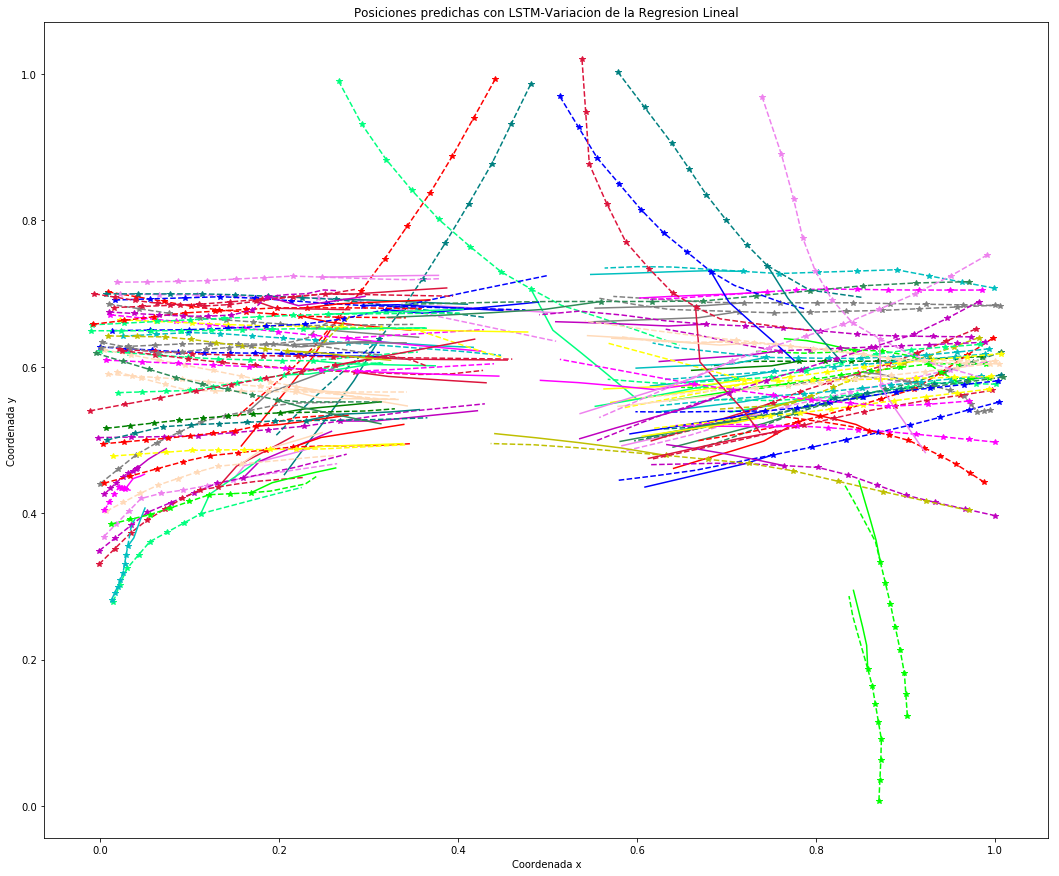

In [26]:
sample_x_persona(datos,8,4)

('TRAYECTORIA PREDICHA DEL PEATON ', 1)
[[480.21479646 288.63183054]
 [461.23876674 287.71298735]
 [442.2120933  286.74015574]
 [423.16407117 285.67235152]]
TRAYECTORIA VERDADERA  
[[480.96   291.6672]
 [462.7264 291.5232]
 [449.9712 290.0736]
 [437.216  288.624 ]]
EL ERROR PROMEDIO DE LA TRAYECTORIA PREDICHA ES = 7.505 
ERROR DE DESPLAZAMIENTO FINAL ES =14.359
('TRAYECTORIA PREDICHA DEL PEATON ', 2)
[[506.47559122 266.59452214]
 [487.96824883 263.92462202]
 [469.26872251 261.07659489]
 [450.67945991 258.29324728]]
TRAYECTORIA VERDADERA  
[[501.8624 267.0672]
 [481.7792 265.8336]
 [461.7792 266.1792]
 [441.7792 266.5296]]
EL ERROR PROMEDIO DE LA TRAYECTORIA PREDICHA ES = 8.076 
ERROR DE DESPLAZAMIENTO FINAL ES =12.127
('TRAYECTORIA PREDICHA DEL PEATON ', 3)
[[323.91435801 311.98999111]
 [344.35783394 296.98772212]
 [364.57176642 281.77007996]
 [384.38275672 266.51524973]]
TRAYECTORIA VERDADERA  
[[329.9712 328.3344]
 [358.5408 320.0016]
 [386.592  311.16  ]
 [414.4128 302.1024]]
EL ERR

('TRAYECTORIA PREDICHA DEL PEATON ', 31)
[[200.17387214 304.36882991]
 [224.3297949  302.26469483]
 [248.43024755 300.23695882]
 [272.37141008 298.30776127]]
TRAYECTORIA VERDADERA  
[[201.3824 308.1936]
 [226.0736 309.5856]
 [250.7648 310.9728]
 [274.496  312.3792]]
EL ERROR PROMEDIO DE LA TRAYECTORIA PREDICHA ES = 9.189 
ERROR DE DESPLAZAMIENTO FINAL ES =14.231
('TRAYECTORIA PREDICHA DEL PEATON ', 32)
[[156.8063568  267.61764738]
 [175.59867818 267.16532508]
 [194.43475579 266.93673507]
 [213.14053649 266.58895876]]
TRAYECTORIA VERDADERA  
[[159.456  271.6656]
 [179.5584 271.6656]
 [199.6544 271.6656]
 [219.7504 271.6656]]
EL ERROR PROMEDIO DE LA TRAYECTORIA PREDICHA ES = 6.552 
ERROR DE DESPLAZAMIENTO FINAL ES =8.334
('TRAYECTORIA PREDICHA DEL PEATON ', 33)
[[487.7060804  263.17356623]
 [470.33370194 258.04810769]
 [453.03054813 252.92051357]
 [435.77067827 247.71343126]]
TRAYECTORIA VERDADERA  
[[493.3312 263.3328]
 [476.6336 262.3248]
 [459.9296 261.312 ]
 [443.232  260.304 ]]
EL E

('TRAYECTORIA PREDICHA DEL PEATON ', 64)
[[209.6063334  284.1820661 ]
 [234.95112411 283.33890608]
 [260.16727053 282.57696364]
 [285.20792161 281.90567936]]
TRAYECTORIA VERDADERA  
[[208.6144 286.152 ]
 [233.0048 287.4336]
 [257.3888 288.72  ]
 [281.7792 290.0016]]
EL ERROR PROMEDIO DE LA TRAYECTORIA PREDICHA ES = 5.568 
ERROR DE DESPLAZAMIENTO FINAL ES =8.792
('TRAYECTORIA PREDICHA DEL PEATON ', 65)
[[212.77635808 328.71201834]
 [237.93343215 327.46490204]
 [263.04969204 326.14731995]
 [288.07773964 324.95234746]]
TRAYECTORIA VERDADERA  
[[217.2672 327.4752]
 [246.4768 326.76  ]
 [275.68   326.0496]
 [304.2688 325.2912]]
EL ERROR PROMEDIO DE LA TRAYECTORIA PREDICHA ES = 10.514 
ERROR DE DESPLAZAMIENTO FINAL ES =16.195
('TRAYECTORIA PREDICHA DEL PEATON ', 66)
[[457.76850057 241.13091285]
 [435.85654996 236.75322364]
 [414.04730868 232.32373033]
 [392.21183015 227.94251924]]
TRAYECTORIA VERDADERA  
[[461.3312 240.7824]
 [439.1104 236.352 ]
 [416.8896 231.9264]
 [394.6688 227.5008]]
EL 

('TRAYECTORIA PREDICHA DEL PEATON ', 94)
[[141.87020586 328.10389641]
 [157.95591052 329.94520196]
 [173.78032693 332.046599  ]
 [189.51344956 334.21777126]]
TRAYECTORIA VERDADERA  
[[133.9712 335.3568]
 [147.9232 335.9808]
 [159.9488 338.4336]
 [170.4704 337.872 ]]
EL ERROR PROMEDIO DE LA TRAYECTORIA PREDICHA ES = 14.264 
ERROR DE DESPLAZAMIENTO FINAL ES =19.390


IndexError: index 11 is out of bounds for axis 0 with size 9

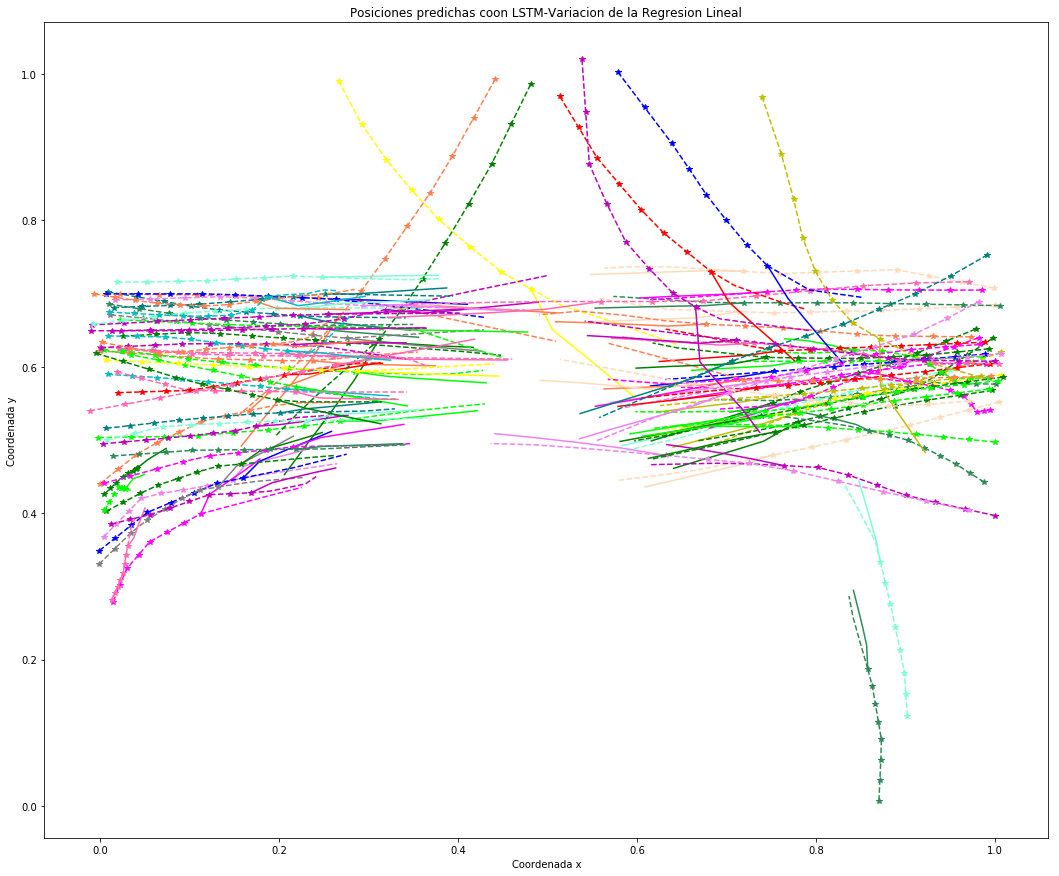

In [27]:
sample_x_persona_pixeles(datos,8,4)